# Semi-Supervised Learning — Revenue Tier Classification

**Goal:** Compare a supervised baseline against three semi-supervised methodologies and select the best-performing model for revenue tier prediction, evaluated on macro F1 on a held-out labeled test set.

**Dataset:** `data_ssl_revenue.csv` produced by the Feature Engineering pipeline.

**Target:** `y_ssl`
- 0 = Low, 1 = Medium, 2 = High, 3 = Blockbuster (labeled)
- -1 = unlabeled

**Models:**
1. GradientBoosting (supervised baseline)
2. RandomForest (supervised baseline)
3. SelfTraining (semi-supervised)
4. LabelSpreading (semi-supervised, graph-based)
5. LabelPropagation (semi-supervised, graph-based)

**Theoretical guarantees:**
- Train/test split on labeled data only
- Test set never participates in pseudo-labeling
- Unlabeled data used only during SSL fitting
- No post-release variables as features
- Scaler fitted only on labeled train
- PCA (if used) fitted only on training data
- All models evaluated on the same labeled test set
- Primary metric: macro F1

In [ ]:
# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import warnings
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.semi_supervised import (
    SelfTrainingClassifier,
    LabelSpreading,
    LabelPropagation,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

warnings.filterwarnings("ignore")
print("All imports successful.")

All imports successful.


## 0. Load Dataset

In [ ]:
# ============================================================
# Load the SSL revenue dataset
# ============================================================
DATA_DIR = "../data"
ARTIFACTS_DIR = "../data"  # save artifacts alongside datasets

df = pd.read_csv(os.path.join(DATA_DIR, "data_ssl_revenue.csv"))
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\ny_ssl value counts:\n{df['y_ssl'].value_counts().sort_index()}")

Dataset shape: (9290, 53)
Columns: ['runtime', 'director_popularity', 'actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity', 'actor5_popularity', 'cast_pop_mean', 'cast_pop_max', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'star_count', 'cast_popularity_std', 'cast_gender_ratio', 'director_is_female', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'num_genres', 'keyword_count', 'lang_en', 'lang_fr', 'lang_es', 'lang_ja', 'lang_de', 'lang_other', 'is_english', 'revenue_missing_flag', 'budget_missing_flag', 'has_budget', 'log_budget', 'has_overview', 'overview_length', 'y_ssl']

y_ssl value counts:
y_ssl
-1    6686
 0     651
 1     6

In [ ]:
df.head()

,runtime,director_popularity,actor1_popularity,actor2_popularity,actor3_popularity,actor4_popularity,actor5_popularity,cast_pop_mean,cast_pop_max,release_month,...,lang_other,is_english,revenue_missing_flag,budget_missing_flag,has_budget,log_budget,has_overview,overview_length,y_ssl,budget_effective
0,148,8.2813,12.2774,5.6445,4.5824,9.6156,4.8289,7.38976,12.2774,7.0,...,0,1,0,0,1,18.890684,1,280,3,18.890684
1,100,5.1258,2.1981,1.9780,1.8252,4.9563,2.1777,2.62706,4.9563,11.0,...,0,1,0,0,1,19.376192,1,286,3,19.376192
2,124,4.0024,9.2587,5.5278,3.4058,17.8153,4.4974,8.10100,17.8153,4.0,...,0,1,0,0,1,19.113828,1,372,3,19.113828
3,95,2.0111,5.8392,2.9334,4.8379,0.7743,2.4183,3.36062,5.8392,7.0,...,0,1,0,0,1,18.049617,1,287,3,18.049617
4,146,1.4636,7.0936,9.4552,4.3204,3.1401,4.5939,5.72064,9.4552,11.0,...,0,1,0,0,1,19.336971,1,298,3,19.336971


In [ ]:
df.columns

Index(['runtime', 'director_popularity', 'actor1_popularity',
       'actor2_popularity', 'actor3_popularity', 'actor4_popularity',
       'actor5_popularity', 'cast_pop_mean', 'cast_pop_max', 'release_month',
       'release_year', 'release_quarter', 'is_summer_release',
       'is_holiday_release', 'star_count', 'cast_popularity_std',
       'cast_gender_ratio', 'director_is_female', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie',
       'genre_Thriller', 'genre_War', 'genre_Western', 'num_genres',
       'keyword_count', 'lang_en', 'lang_fr', 'lang_es', 'lang_ja', 'lang_de',
       'lang_other', 'is_english', 'revenue_missing_flag',
       'budget_missing_flag', 'has_budget', 'log_budget', 'has_overview',
       'overview_length

---
## Validation 1 — Leakage Prevention

Remove post-release or target-leakage columns while keeping valid pre-release signals:
- Remove columns containing: `vote`, `review`, `rating`, `revenue`
- Remove movie popularity columns (if present)
- Keep: `director_popularity`, `cast_popularity_*`, and `actor1..actor5_popularity`
- Keep: `has_budget` and `log_budget`
- Add interaction: `budget_effective = has_budget * log_budget`
- Keep `y_ssl` only as target

In [ ]:
# ============================================================
# Validation 1 — Leakage prevention
# ============================================================
base_leakage_keywords = ["vote", "review", "rating", "revenue"]
allowed_budget_features = {"has_budget", "log_budget", "budget_effective"}

# Add theory-driven interaction (active only when budget exists)
if {"has_budget", "log_budget"}.issubset(df.columns):
    df["budget_effective"] = df["has_budget"] * df["log_budget"]
else:
    print("Warning: has_budget or log_budget not found; budget_effective not created.")

# All columns except y_ssl are candidate features
candidate_features = [c for c in df.columns if c != "y_ssl"]

def is_leaked_feature(col_name: str) -> bool:
    """
    Remove direct leakage/post-release fields.
    Keep pre-release talent popularity features and selected budget proxies.
    """
    name = col_name.lower()

    # Keep explicitly allowed budget-derived features
    if name in allowed_budget_features:
        return False

    # Remove direct leakage keywords
    if any(kw in name for kw in base_leakage_keywords):
        return True

    # For budget-like fields, keep only whitelisted features above
    if "budget" in name and name not in allowed_budget_features:
        return True

    # Handle popularity carefully:
    # - remove movie popularity columns (if any)
    # - keep director/actor/cast popularity fields
    if "popularity" in name:
        allowed_talent_popularity = (
            name == "director_popularity"
            or name == "cast_popularity_std"
            or name in {
                "actor1_popularity",
                "actor2_popularity",
                "actor3_popularity",
                "actor4_popularity",
                "actor5_popularity",
            }
)
        if not allowed_talent_popularity:
            return True

    return False

leaked_cols = [c for c in candidate_features if is_leaked_feature(c)]
feature_cols = [c for c in candidate_features if c not in leaked_cols]

required_actor_popularity = [
    "actor1_popularity",
    "actor2_popularity",
    "actor3_popularity",
    "actor4_popularity",
    "actor5_popularity",
]
missing_actor_popularity = [c for c in required_actor_popularity if c not in feature_cols]
assert not missing_actor_popularity, (
    f"Missing actor popularity features in training set: {missing_actor_popularity}"
)

print(f"Candidate features before filter: {len(candidate_features)}")
print(f"Leaked columns removed ({len(leaked_cols)}): {leaked_cols}")
print(f"\nFinal feature count: {len(feature_cols)}")
print(f"First 20 features: {feature_cols[:20]}")
print("\nGuaranteed actor popularity features included:", required_actor_popularity)
print(
    "Budget features included:",
    [c for c in ["has_budget", "log_budget", "budget_effective"] if c in feature_cols],
)

Candidate features before filter: 53
Leaked columns removed (2): ['revenue_missing_flag', 'budget_missing_flag']

Final feature count: 51
First 20 features: ['runtime', 'director_popularity', 'actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity', 'actor5_popularity', 'cast_pop_mean', 'cast_pop_max', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'star_count', 'cast_popularity_std', 'cast_gender_ratio', 'director_is_female', 'genre_Action', 'genre_Adventure']

Guaranteed actor popularity features included: ['actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity', 'actor5_popularity']
Budget features included: ['has_budget', 'log_budget', 'budget_effective']


## Validation 2 — Class Distribution

In [ ]:
# ============================================================
# Validation 2 — Class distribution (labeled data)
# ============================================================
labeled_mask = df["y_ssl"] != -1
df_labeled = df[labeled_mask].copy()

class_counts = df_labeled["y_ssl"].value_counts().sort_index()
print(f"Class distribution (labeled rows):")
tier_names = {0: "Low", 1: "Medium", 2: "High", 3: "Blockbuster"}
for cls, cnt in class_counts.items():
    print(f"  {cls} ({tier_names.get(cls, '?')}): {cnt}")

n_classes = df_labeled["y_ssl"].nunique()
print(f"\nNumber of classes: {n_classes}")
assert n_classes == 4, f"Expected 4 classes, got {n_classes}"
print(f"Total labeled rows: {len(df_labeled)}")

Class distribution (labeled rows):
  0 (Low): 651
  1 (Medium): 651
  2 (High): 651
  3 (Blockbuster): 651

Number of classes: 4
Total labeled rows: 2604


## Validation 3 — Unlabeled Proportion

In [ ]:
# ============================================================
# Validation 3 — Unlabeled proportion
# ============================================================
unlabeled_mask = df["y_ssl"] == -1
n_unlabeled = unlabeled_mask.sum()
pct_unlabeled = n_unlabeled / len(df) * 100

print(f"Unlabeled rows:  {n_unlabeled}")
print(f"Percentage:      {pct_unlabeled:.2f}%")
print(f"Labeled rows:    {(~unlabeled_mask).sum()}")
print(f"Total rows:      {len(df)}")

Unlabeled rows:  6686
Percentage:      71.97%
Labeled rows:    2604
Total rows:      9290


## Validation 4 — Feature Dimensionality

In [ ]:
# ============================================================
# Validation 4 — Feature dimensionality
# ============================================================
n_features = len(feature_cols)
USE_PCA = n_features > 100

print(f"Total feature columns: {n_features}")
if USE_PCA:
    print(">> Feature count > 100 — will apply PCA (95% variance) for graph-based SSL methods.")
else:
    print(">> Feature count <= 100 — no PCA needed for graph-based methods.")

Total feature columns: 51
>> Feature count <= 100 — no PCA needed for graph-based methods.


## Validation 5 — Missing Features

In [ ]:
# ============================================================
# Validation 5 — Missing features
# ============================================================
X_all = df[feature_cols].copy()
y_all = df["y_ssl"].copy()

missing_before = X_all.isnull().sum()
total_missing_before = missing_before.sum()
print(f"Total missing values BEFORE imputation: {total_missing_before}")

if total_missing_before > 0:
    print(f"\nMissing per column (non-zero):")
    print(missing_before[missing_before > 0])
    
    # Apply median imputation for numeric columns
    imputer = SimpleImputer(strategy="median")
    X_all_imputed = pd.DataFrame(
        imputer.fit_transform(X_all),
        columns=feature_cols,
        index=X_all.index
    )
    total_missing_after = X_all_imputed.isnull().sum().sum()
    print(f"\nTotal missing values AFTER imputation: {total_missing_after}")
    X_all = X_all_imputed
else:
    print("No missing values — no imputation needed.")

print(f"\nFinal feature matrix shape: {X_all.shape}")

Total missing values BEFORE imputation: 0
No missing values — no imputation needed.

Final feature matrix shape: (9290, 51)


---
# Experiment

## Step 1 — Split Labeled Data

In [ ]:
# ============================================================
# Step 1 — Split labeled data only
# ============================================================

# Separate labeled and unlabeled feature matrices
X_labeled = X_all[labeled_mask].copy()
y_labeled = y_all[labeled_mask].copy()
X_unlabeled = X_all[unlabeled_mask].copy()

print(f"Labeled:   X={X_labeled.shape}  y={y_labeled.shape}")
print(f"Unlabeled: X={X_unlabeled.shape}")

# Stratified train/test split on labeled data
X_train_labeled, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

print(f"\nAfter split:")
print(f"  X_train_labeled: {X_train_labeled.shape}")
print(f"  X_test:          {X_test.shape}")
print(f"  y_train:         {y_train.shape}  distribution: {dict(y_train.value_counts().sort_index())}")
print(f"  y_test:          {y_test.shape}  distribution: {dict(y_test.value_counts().sort_index())}")
print(f"  X_unlabeled:     {X_unlabeled.shape}")
print(f"\n>> Test set ({len(y_test)} rows) will NEVER be used during SSL fitting.")

Labeled:   X=(2604, 51)  y=(2604,)
Unlabeled: X=(6686, 51)

After split:
  X_train_labeled: (2083, 51)
  X_test:          (521, 51)
  y_train:         (2083,)  distribution: {0: np.int64(521), 1: np.int64(521), 2: np.int64(520), 3: np.int64(521)}
  y_test:          (521,)  distribution: {0: np.int64(130), 1: np.int64(130), 2: np.int64(131), 3: np.int64(130)}
  X_unlabeled:     (6686, 51)

>> Test set (521 rows) will NEVER be used during SSL fitting.


## Step 2 — Preprocessing (StandardScaler)

In [ ]:
# ============================================================
# Step 2 — Fit StandardScaler on labeled train ONLY
# ============================================================
scaler = StandardScaler()
scaler.fit(X_train_labeled)

X_train_s = pd.DataFrame(
    scaler.transform(X_train_labeled),
    columns=feature_cols, index=X_train_labeled.index
)
X_test_s = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols, index=X_test.index
)
X_unlabeled_s = pd.DataFrame(
    scaler.transform(X_unlabeled),
    columns=feature_cols, index=X_unlabeled.index
)

print("StandardScaler fitted on labeled training data only.")
print(f"  X_train_s:     {X_train_s.shape}")
print(f"  X_test_s:      {X_test_s.shape}")
print(f"  X_unlabeled_s: {X_unlabeled_s.shape}")

StandardScaler fitted on labeled training data only.
  X_train_s:     (2083, 51)
  X_test_s:      (521, 51)
  X_unlabeled_s: (6686, 51)


## Step 2.5 — Fine Tuning (Only Tunable Models)

We tune only models/hyperparameters that are methodologically valid and impactful:
- `GradientBoostingClassifier`
- `RandomForestClassifier`
- `SelfTrainingClassifier` threshold (using unlabeled data only inside training folds)

Tuning uses **only labeled training data for validation** (macro F1), keeping the held-out test set untouched.

In [ ]:
# ============================================================
# Step 2.5a — Tune supervised baselines + SelfTraining threshold
# ============================================================
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "f1_macro"

# --- Tune GradientBoosting ---
gb_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions={
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.03, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 1.0],
        "min_samples_leaf": [1, 3, 5],
    },
    n_iter=12,
    scoring=scoring,
    cv=cv_inner,
    n_jobs=-1,
    random_state=42,
)
gb_search.fit(X_train_s, y_train)

# --- Tune RandomForest ---
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions={
        "n_estimators": [200, 400, 600],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None],
        "class_weight": [None, "balanced"],
    },
    n_iter=16,
    scoring=scoring,
    cv=cv_inner,
    n_jobs=-1,
    random_state=42,
)
rf_search.fit(X_train_s, y_train)

# --- Tune SelfTraining threshold (with unlabeled used only in training folds) ---
candidate_thresholds = [0.70, 0.80, 0.90, 0.95]
threshold_scores = {}

for thr in candidate_thresholds:
    fold_scores = []
    for tr_idx, val_idx in cv_inner.split(X_train_s, y_train):
        X_tr_lbl = X_train_s.iloc[tr_idx].reset_index(drop=True)
        y_tr_lbl = y_train.iloc[tr_idx].reset_index(drop=True)
        X_val = X_train_s.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        X_ssl_fold = pd.concat([X_tr_lbl, X_unlabeled_s], axis=0).reset_index(drop=True)
        y_ssl_fold = pd.concat([
            y_tr_lbl,
            pd.Series([-1] * len(X_unlabeled_s))
        ], axis=0).reset_index(drop=True)

        st_fold = SelfTrainingClassifier(
            estimator=RandomForestClassifier(
                random_state=42,
                **rf_search.best_params_
            ),
            threshold=thr,
            verbose=False
)
        st_fold.fit(X_ssl_fold, y_ssl_fold)
        y_val_pred = st_fold.predict(X_val)
        fold_scores.append(f1_score(y_val, y_val_pred, average="macro"))

    threshold_scores[thr] = float(np.mean(fold_scores))

best_st_threshold = max(threshold_scores, key=threshold_scores.get)

best_params = {
    "GradientBoosting": gb_search.best_params_,
    "RandomForest": rf_search.best_params_,
    "SelfTraining_threshold": best_st_threshold,
}

print("Fine tuning complete (labeled-train CV only):")
print(f"  GradientBoosting best macro F1: {gb_search.best_score_:.4f}")
print(f"  GradientBoosting params: {best_params['GradientBoosting']}")
print(f"  RandomForest best macro F1: {rf_search.best_score_:.4f}")
print(f"  RandomForest params: {best_params['RandomForest']}")
print(f"  SelfTraining threshold scores: {threshold_scores}")
print(f"  SelfTraining best threshold: {best_params['SelfTraining_threshold']}")

Fine tuning complete (labeled-train CV only):
  GradientBoosting best macro F1: 0.5928
  GradientBoosting params: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.03}
  RandomForest best macro F1: 0.5948
  RandomForest params: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced'}
  SelfTraining threshold scores: {0.7: 0.5931365549749019, 0.8: 0.5778151586792818, 0.9: 0.5417976377218044, 0.95: 0.5732023343184968}
  SelfTraining best threshold: 0.7


## Step 3 — Supervised Models (Base vs Tuned)

For each tunable supervised model, we evaluate both:
- **Base**: default hyperparameters
- **Tuned**: hyperparameters selected by CV on labeled train only

In [ ]:
# ============================================================
# Helper: evaluate a model and return metrics dict
# ============================================================
def evaluate_model(model, X_eval, y_eval, model_name, notes=""):
    """
    Predict on X_eval and compute accuracy, macro_f1, macro_precision, macro_recall, confusion matrix.
    Returns a dict suitable for the comparison table.
    """
    y_pred = model.predict(X_eval)
    acc = accuracy_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred, average="macro")
    precision = precision_score(y_eval, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_eval, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_eval, y_pred)
    
    print(f"\n{'='*60}")
    print(f"  {model_name}")
    print(f"{'='*60}")
    print(f"  Accuracy:         {acc:.4f}")
    print(f"  Macro F1:         {f1:.4f}")
    print(f"  Macro Precision:  {precision:.4f}")
    print(f"  Macro Recall:     {recall:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_eval, y_pred, target_names=["Low", "Medium", "High", "Blockbuster"]))
    print(f"  Confusion Matrix:")
    print(cm)
    
    return {
        "model_name": model_name,
        "accuracy": round(acc, 4),
        "macro_f1": round(f1, 4),
        "macro_precision": round(precision, 4),
        "macro_recall": round(recall, 4),
        "notes": notes,
        "_model": model,
        "_y_pred": y_pred,
        "_cm": cm,
    }

print("Evaluation helper defined.")

Evaluation helper defined.


In [ ]:
# ============================================================
# Step 3a — Gradient Boosting (base + tuned)
# ============================================================
results = []

# Base (no fine tuning)
gb_base = GradientBoostingClassifier(random_state=42)
gb_base.fit(X_train_s, y_train)

res_gb_base = evaluate_model(
    gb_base,
    X_test_s,
    y_test,
    "GradientBoosting (supervised, base)",
    notes="Default hyperparameters (no fine tuning)",
)
results.append(res_gb_base)

# Tuned
gb_tuned = GradientBoostingClassifier(
    random_state=42,
    **best_params["GradientBoosting"]
)
gb_tuned.fit(X_train_s, y_train)

res_gb_tuned = evaluate_model(
    gb_tuned,
    X_test_s,
    y_test,
    "GradientBoosting (supervised, tuned)",
    notes="RandomizedSearchCV on labeled train (macro F1)",
)
results.append(res_gb_tuned)


  GradientBoosting (supervised, base)
  Accuracy:         0.6027
  Macro F1:         0.6032
  Macro Precision:  0.6061
  Macro Recall:     0.6028

  Classification Report:
              precision    recall  f1-score   support

         Low       0.69      0.72      0.70       130
      Medium       0.50      0.45      0.47       130
        High       0.49      0.56      0.52       131
 Blockbuster       0.75      0.69      0.72       130

    accuracy                           0.60       521
   macro avg       0.61      0.60      0.60       521
weighted avg       0.61      0.60      0.60       521

  Confusion Matrix:
[[93 24 10  3]
 [36 58 32  4]
 [ 6 29 73 23]
 [ 0  6 34 90]]

  GradientBoosting (supervised, tuned)
  Accuracy:         0.6027
  Macro F1:         0.6024
  Macro Precision:  0.6035
  Macro Recall:     0.6027

  Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.70      0.68       130
      Medium       0.45     

In [ ]:
# ============================================================
# Step 3b — Random Forest (base + tuned)
# ============================================================
# Base (no fine tuning)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_s, y_train)

res_rf_base = evaluate_model(
    rf_base,
    X_test_s,
    y_test,
    "RandomForest (supervised, base)",
    notes="Default hyperparameters (no fine tuning)",
)
results.append(res_rf_base)

# Tuned
rf_tuned = RandomForestClassifier(
    random_state=42,
    **best_params["RandomForest"]
)
rf_tuned.fit(X_train_s, y_train)

res_rf_tuned = evaluate_model(
    rf_tuned,
    X_test_s,
    y_test,
    "RandomForest (supervised, tuned)",
    notes="RandomizedSearchCV on labeled train (macro F1)",
)
results.append(res_rf_tuned)


  RandomForest (supervised, base)
  Accuracy:         0.6161
  Macro F1:         0.6172
  Macro Precision:  0.6228
  Macro Recall:     0.6161

  Classification Report:
              precision    recall  f1-score   support

         Low       0.68      0.72      0.70       130
      Medium       0.47      0.44      0.45       130
        High       0.54      0.63      0.58       131
 Blockbuster       0.80      0.68      0.74       130

    accuracy                           0.62       521
   macro avg       0.62      0.62      0.62       521
weighted avg       0.62      0.62      0.62       521

  Confusion Matrix:
[[93 27  7  3]
 [39 57 31  3]
 [ 5 28 82 16]
 [ 0  9 32 89]]

  RandomForest (supervised, tuned)
  Accuracy:         0.6065
  Macro F1:         0.6064
  Macro Precision:  0.6143
  Macro Recall:     0.6065

  Classification Report:
              precision    recall  f1-score   support

         Low       0.66      0.71      0.68       130
      Medium       0.48      0.42   

## Step 4 — Prepare Semi-Supervised Training Data

In [ ]:
# ============================================================
# Step 4 — Concatenate labeled train + unlabeled for SSL
# ============================================================
X_train_ssl = pd.concat([X_train_s, X_unlabeled_s], axis=0).reset_index(drop=True)
y_train_ssl = pd.concat([
    y_train.reset_index(drop=True),
    pd.Series([-1] * len(X_unlabeled_s))
], axis=0).reset_index(drop=True)

print(f"SSL training data:")
print(f"  X_train_ssl: {X_train_ssl.shape}")
print(f"  y_train_ssl: {y_train_ssl.shape}")
print(f"  Labeled in SSL train:   {(y_train_ssl != -1).sum()}")
print(f"  Unlabeled in SSL train: {(y_train_ssl == -1).sum()}")
print(f"\n>> Test set ({len(y_test)} rows) is EXCLUDED from SSL training data.")

SSL training data:
  X_train_ssl: (8769, 51)
  y_train_ssl: (8769,)
  Labeled in SSL train:   2083
  Unlabeled in SSL train: 6686

>> Test set (521 rows) is EXCLUDED from SSL training data.


## Step 5 — Semi-Supervised Models

### Model A: Self-Training

In [ ]:
# ============================================================
# Model A — Self-Training (base + tuned)
# ============================================================
# Base (no fine tuning)
st_base_default = RandomForestClassifier(random_state=42)
st_clf_base = SelfTrainingClassifier(
    estimator=st_base_default,
    threshold=0.9,
    verbose=False
)
st_clf_base.fit(X_train_ssl, y_train_ssl)

if hasattr(st_clf_base, "labeled_iter_"):
    n_pseudo_base = int((st_clf_base.labeled_iter_ > 0).sum())
    st_base_notes = f"Pseudo-labeled: {n_pseudo_base} samples; threshold=0.9"
else:
    st_base_notes = "Pseudo-label count not available"

res_st_base = evaluate_model(
    st_clf_base,
    X_test_s,
    y_test,
    "SelfTraining (SSL, base)",
    notes=st_base_notes,
)
results.append(res_st_base)

# Tuned
st_base_tuned = RandomForestClassifier(
    random_state=42,
    **best_params["RandomForest"]
)
st_clf_tuned = SelfTrainingClassifier(
    estimator=st_base_tuned,
    threshold=best_params["SelfTraining_threshold"],
    verbose=False
)
st_clf_tuned.fit(X_train_ssl, y_train_ssl)

if hasattr(st_clf_tuned, "labeled_iter_"):
    n_pseudo_tuned = int((st_clf_tuned.labeled_iter_ > 0).sum())
    st_tuned_notes = (
        f"Pseudo-labeled: {n_pseudo_tuned} samples; "
        f"threshold={best_params['SelfTraining_threshold']}"
    )
else:
    st_tuned_notes = "Pseudo-label count not available"

res_st_tuned = evaluate_model(
    st_clf_tuned,
    X_test_s,
    y_test,
    "SelfTraining (SSL, tuned)",
    notes=st_tuned_notes,
)
results.append(res_st_tuned)


  SelfTraining (SSL, base)
  Accuracy:         0.5931
  Macro F1:         0.5909
  Macro Precision:  0.5976
  Macro Recall:     0.5931

  Classification Report:
              precision    recall  f1-score   support

         Low       0.64      0.71      0.67       130
      Medium       0.45      0.35      0.40       130
        High       0.49      0.61      0.54       131
 Blockbuster       0.81      0.70      0.75       130

    accuracy                           0.59       521
   macro avg       0.60      0.59      0.59       521
weighted avg       0.60      0.59      0.59       521

  Confusion Matrix:
[[92 24 12  2]
 [44 46 39  1]
 [ 6 26 80 19]
 [ 1  6 32 91]]

  SelfTraining (SSL, tuned)
  Accuracy:         0.6180
  Macro F1:         0.6247
  Macro Precision:  0.6399
  Macro Recall:     0.6180

  Classification Report:
              precision    recall  f1-score   support

         Low       0.74      0.65      0.69       130
      Medium       0.49      0.53      0.51       

### PCA Preparation for Graph-Based Methods

LabelSpreading and LabelPropagation use distance-based kernels. If the feature dimensionality is high (>100), we reduce it with PCA (retaining 95% explained variance). PCA is fitted **only on the SSL training data** to prevent leakage.

In [ ]:
# ============================================================
# PCA preparation for graph-based SSL methods (if needed)
# ============================================================
if USE_PCA:
    print(f"Feature count = {n_features} > 100 — applying PCA (95% variance)")
    pca = PCA(n_components=0.95, random_state=42)
    pca.fit(X_train_ssl)  # fit only on SSL training data
    
    X_train_ssl_pca = pca.transform(X_train_ssl)
    X_test_s_pca = pca.transform(X_test_s)
    
    print(f"  PCA components retained: {pca.n_components_}")
    print(f"  Explained variance:      {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  X_train_ssl_pca shape:   {X_train_ssl_pca.shape}")
    print(f"  X_test_s_pca shape:      {X_test_s_pca.shape}")
else:
    print(f"Feature count = {n_features} <= 100 — using original features for graph-based methods.")
    X_train_ssl_pca = X_train_ssl.values
    X_test_s_pca = X_test_s.values
    pca = None

Feature count = 51 <= 100 — using original features for graph-based methods.


### Step 5.1 — Graph SSL Hyperparameter Tuning

Tune `n_neighbors` for graph-based SSL models using CV on labeled training folds only.
Unlabeled rows are included only in fold training (never in validation).

In [ ]:
# ============================================================
# Step 5.1a — Tune n_neighbors for LabelSpreading/LabelPropagation
# ============================================================
neighbor_candidates = [5, 10, 15, 20, 30]
cv_graph = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def _prepare_graph_spaces(X_lbl_tr, y_lbl_tr, X_lbl_val):
    """Fit transforms on SSL-train only, then transform validation split."""
    X_ssl_fold = pd.concat([X_lbl_tr, X_unlabeled_s], axis=0).reset_index(drop=True)
    y_ssl_fold = pd.concat([
        y_lbl_tr.reset_index(drop=True),
        pd.Series([-1] * len(X_unlabeled_s))
    ], axis=0).reset_index(drop=True)

    if USE_PCA:
        pca_fold = PCA(n_components=0.95, random_state=42)
        pca_fold.fit(X_ssl_fold)
        X_ssl_fold_space = pca_fold.transform(X_ssl_fold)
        X_val_space = pca_fold.transform(X_lbl_val)
    else:
        X_ssl_fold_space = X_ssl_fold.values
        X_val_space = X_lbl_val.values

    return X_ssl_fold_space, y_ssl_fold, X_val_space

scores_ls = {}
scores_lp = {}

for k in neighbor_candidates:
    fold_ls = []
    fold_lp = []

    for tr_idx, val_idx in cv_graph.split(X_train_s, y_train):
        X_lbl_tr = X_train_s.iloc[tr_idx].reset_index(drop=True)
        y_lbl_tr = y_train.iloc[tr_idx].reset_index(drop=True)
        X_lbl_val = X_train_s.iloc[val_idx]
        y_lbl_val = y_train.iloc[val_idx]

        X_ssl_fold_space, y_ssl_fold, X_val_space = _prepare_graph_spaces(
            X_lbl_tr, y_lbl_tr, X_lbl_val
)

        ls_fold = LabelSpreading(kernel="knn", n_neighbors=k)
        ls_fold.fit(X_ssl_fold_space, y_ssl_fold)
        y_pred_ls = ls_fold.predict(X_val_space)
        fold_ls.append(f1_score(y_lbl_val, y_pred_ls, average="macro"))

        lp_fold = LabelPropagation(kernel="knn", n_neighbors=k)
        lp_fold.fit(X_ssl_fold_space, y_ssl_fold)
        y_pred_lp = lp_fold.predict(X_val_space)
        fold_lp.append(f1_score(y_lbl_val, y_pred_lp, average="macro"))

    scores_ls[k] = float(np.mean(fold_ls))
    scores_lp[k] = float(np.mean(fold_lp))

best_k_ls = max(scores_ls, key=scores_ls.get)
best_k_lp = max(scores_lp, key=scores_lp.get)

best_params["LabelSpreading_n_neighbors"] = best_k_ls
best_params["LabelPropagation_n_neighbors"] = best_k_lp

print("Graph SSL tuning complete (labeled-train CV only):")
print(f"  LabelSpreading scores:  {scores_ls}")
print(f"  LabelSpreading best k:  {best_k_ls}")
print(f"  LabelPropagation scores:{scores_lp}")
print(f"  LabelPropagation best k:{best_k_lp}")

Graph SSL tuning complete (labeled-train CV only):
  LabelSpreading scores:  {5: 0.46305170856413236, 10: 0.4920651319556584, 15: 0.49599457248322326, 20: 0.49606955569845185, 30: 0.5013144164810414}
  LabelSpreading best k:  30
  LabelPropagation scores:{5: 0.46925002124310994, 10: 0.4879906979850097, 15: 0.4944663907265405, 20: 0.5022991624480225, 30: 0.4945582492888407}
  LabelPropagation best k:20


### Model B: Label Spreading

In [ ]:
# ============================================================
# Model B — Label Spreading (base + tuned)
# ============================================================
pca_note = f"PCA to {X_train_ssl_pca.shape[1]}d" if USE_PCA else "No PCA"

# Base (no fine tuning)
ls_base = LabelSpreading(kernel="knn", n_neighbors=10)
ls_base.fit(X_train_ssl_pca, y_train_ssl)

res_ls_base = evaluate_model(
    ls_base,
    X_test_s_pca,
    y_test,
    "LabelSpreading (SSL, base)",
    notes=f"kernel=knn, n_neighbors=10, {pca_note}",
)
results.append(res_ls_base)

# Tuned
ls_tuned = LabelSpreading(
    kernel="knn",
    n_neighbors=best_params["LabelSpreading_n_neighbors"]
)
ls_tuned.fit(X_train_ssl_pca, y_train_ssl)

res_ls_tuned = evaluate_model(
    ls_tuned,
    X_test_s_pca,
    y_test,
    "LabelSpreading (SSL, tuned)",
    notes=(
        f"kernel=knn, n_neighbors={best_params['LabelSpreading_n_neighbors']}, "
        f"{pca_note}"
    ),
)
results.append(res_ls_tuned)


  LabelSpreading (SSL, base)
  Accuracy:         0.4952
  Macro F1:         0.4943
  Macro Precision:  0.4937
  Macro Recall:     0.4954

  Classification Report:
              precision    recall  f1-score   support

         Low       0.59      0.61      0.60       130
      Medium       0.36      0.33      0.34       130
        High       0.39      0.41      0.40       131
 Blockbuster       0.64      0.63      0.63       130

    accuracy                           0.50       521
   macro avg       0.49      0.50      0.49       521
weighted avg       0.49      0.50      0.49       521

  Confusion Matrix:
[[79 25 19  7]
 [41 43 37  9]
 [10 36 54 31]
 [ 4 16 28 82]]

  LabelSpreading (SSL, tuned)
  Accuracy:         0.5470
  Macro F1:         0.5420
  Macro Precision:  0.5415
  Macro Recall:     0.5472

  Classification Report:
              precision    recall  f1-score   support

         Low       0.60      0.67      0.64       130
      Medium       0.41      0.32      0.36   

### Model C: Label Propagation

In [ ]:
# ============================================================
# Model C — Label Propagation (base + tuned)
# ============================================================
# Base (no fine tuning)
lp_base = LabelPropagation(kernel="knn", n_neighbors=10)
lp_base.fit(X_train_ssl_pca, y_train_ssl)

res_lp_base = evaluate_model(
    lp_base,
    X_test_s_pca,
    y_test,
    "LabelPropagation (SSL, base)",
    notes=f"kernel=knn, n_neighbors=10, {pca_note}",
)
results.append(res_lp_base)

# Tuned
lp_tuned = LabelPropagation(
    kernel="knn",
    n_neighbors=best_params["LabelPropagation_n_neighbors"]
)
lp_tuned.fit(X_train_ssl_pca, y_train_ssl)

res_lp_tuned = evaluate_model(
    lp_tuned,
    X_test_s_pca,
    y_test,
    "LabelPropagation (SSL, tuned)",
    notes=(
        f"kernel=knn, n_neighbors={best_params['LabelPropagation_n_neighbors']}, "
        f"{pca_note}"
    ),
)
results.append(res_lp_tuned)


  LabelPropagation (SSL, base)
  Accuracy:         0.5029
  Macro F1:         0.5011
  Macro Precision:  0.5000
  Macro Recall:     0.5031

  Classification Report:
              precision    recall  f1-score   support

         Low       0.58      0.64      0.61       130
      Medium       0.39      0.37      0.38       130
        High       0.40      0.40      0.40       131
 Blockbuster       0.62      0.61      0.61       130

    accuracy                           0.50       521
   macro avg       0.50      0.50      0.50       521
weighted avg       0.50      0.50      0.50       521

  Confusion Matrix:
[[83 21 18  8]
 [44 48 30  8]
 [10 37 52 32]
 [ 5 17 29 79]]

  LabelPropagation (SSL, tuned)
  Accuracy:         0.5278
  Macro F1:         0.5277
  Macro Precision:  0.5283
  Macro Recall:     0.5280

  Classification Report:
              precision    recall  f1-score   support

         Low       0.59      0.64      0.61       130
      Medium       0.37      0.35      0.3

---
## Step 6 — Comparison & Best Model Selection

In [ ]:
# ============================================================
# Step 6 — Comparison table & best model selection
# ============================================================
comparison_df = pd.DataFrame([
    {
        "model_name": r["model_name"],
        "accuracy": r["accuracy"],
        "macro_f1": r["macro_f1"],
        "macro_precision": r["macro_precision"],
        "macro_recall": r["macro_recall"],
        "notes": r["notes"],
    }
    for r in results
])

# Sort by macro_f1 (primary), then macro_precision, then accuracy
comparison_df = comparison_df.sort_values(
    ["macro_f1", "macro_precision", "accuracy"], ascending=[False, False, False]
).reset_index(drop=True)

print("="*100)
print("  MODEL COMPARISON TABLE")
print("="*100)
print(comparison_df.to_string(index=False))

# Select best model
best_idx = comparison_df.index[0]
best_name = comparison_df.loc[best_idx, "model_name"]
best_f1 = comparison_df.loc[best_idx, "macro_f1"]
best_acc = comparison_df.loc[best_idx, "accuracy"]
best_result = [r for r in results if r["model_name"] == best_name][0]
best_model = best_result["_model"]

print(f"\n>> BEST MODEL: {best_name}")
print(f"   Macro F1:         {best_f1}")
print(f"   Accuracy:         {best_acc}")
print(f"   Macro Precision:  {best_result['macro_precision']}")
print(f"   Macro Recall:     {best_result['macro_recall']}")

  MODEL COMPARISON TABLE
                          model_name  accuracy  macro_f1  macro_precision  macro_recall                                          notes
           SelfTraining (SSL, tuned)    0.6180    0.6247           0.6399        0.6180    Pseudo-labeled: 5968 samples; threshold=0.7
     RandomForest (supervised, base)    0.6161    0.6172           0.6228        0.6161       Default hyperparameters (no fine tuning)
    RandomForest (supervised, tuned)    0.6065    0.6064           0.6143        0.6065 RandomizedSearchCV on labeled train (macro F1)
 GradientBoosting (supervised, base)    0.6027    0.6032           0.6061        0.6028       Default hyperparameters (no fine tuning)
GradientBoosting (supervised, tuned)    0.6027    0.6024           0.6035        0.6027 RandomizedSearchCV on labeled train (macro F1)
            SelfTraining (SSL, base)    0.5931    0.5909           0.5976        0.5931    Pseudo-labeled: 5054 samples; threshold=0.9
         LabelSpreading (SSL, 

## Step 7 — Save Artifacts

In [ ]:
# ============================================================
# Step 7a — Save comparison table
# ============================================================
comp_path = os.path.join(ARTIFACTS_DIR, "ssl_model_comparison.csv")
comparison_df.to_csv(comp_path, index=False)
print(f"Saved comparison table: {comp_path}")

Saved comparison table: ../data\ssl_model_comparison.csv


In [ ]:
# ============================================================
# Step 7b — Save best model and scaler
# ============================================================
model_path = os.path.join(ARTIFACTS_DIR, "best_ssl_model.joblib")
scaler_path = os.path.join(ARTIFACTS_DIR, "ssl_scaler.joblib")

joblib.dump(best_model, model_path)
print(f"Saved best model ({best_name}): {model_path}")

joblib.dump(scaler, scaler_path)
print(f"Saved scaler: {scaler_path}")

# Also save PCA if it was used
if pca is not None:
    pca_path = os.path.join(ARTIFACTS_DIR, "ssl_pca.joblib")
    joblib.dump(pca, pca_path)
    print(f"Saved PCA: {pca_path}")

Saved best model (SelfTraining (SSL, tuned)): ../data\best_ssl_model.joblib
Saved scaler: ../data\ssl_scaler.joblib


Saved confusion matrix plot: ../data\best_ssl_confusion_matrix.png


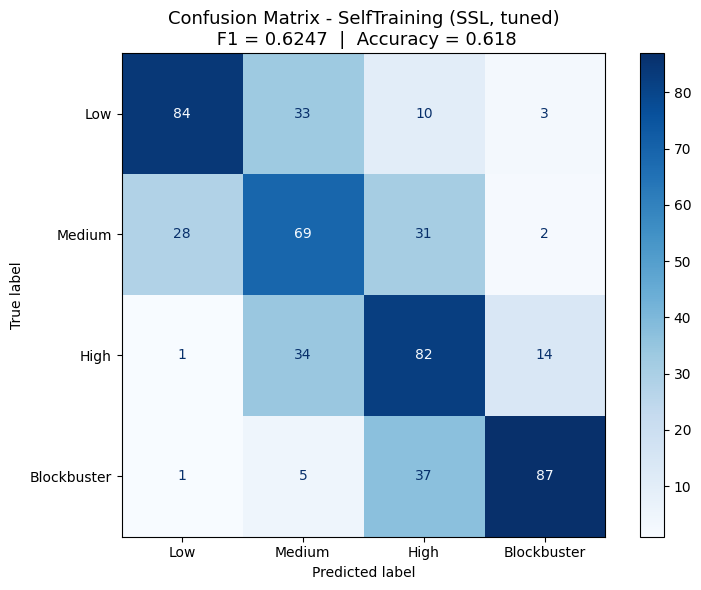

In [ ]:
# ============================================================
# Step 7c — Confusion matrix plot for best model
# ============================================================
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(
    confusion_matrix=best_result["_cm"],
    display_labels=["Low", "Medium", "High", "Blockbuster"]
).plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Confusion Matrix - {best_name}\n F1 = {best_f1}  |  Accuracy = {best_acc}", fontsize=13)
plt.tight_layout()

cm_path = os.path.join(ARTIFACTS_DIR, "best_ssl_confusion_matrix.png")
fig.savefig(cm_path, dpi=150, bbox_inches="tight")
print(f"Saved confusion matrix plot: {cm_path}")
plt.show()

## Step 7d — Confusion Matrix (Percentages)

Saved percentage confusion matrix plot: ../data\best_ssl_confusion_matrix_pct.png


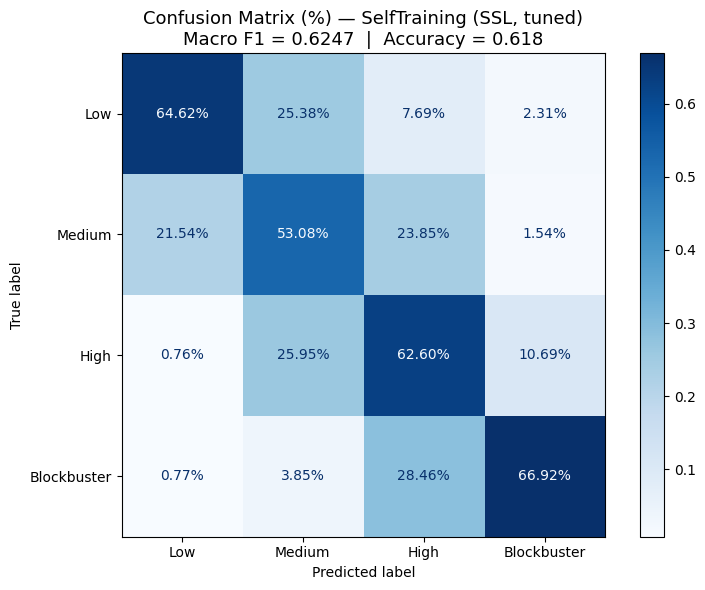

In [ ]:
# ============================================================
# Step 7d — Confusion matrix plot for best model (percentages)
# ============================================================
fig_pct, ax_pct = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    best_result["_y_pred"],
    display_labels=["Low", "Medium", "High", "Blockbuster"],
    normalize="true",
    cmap="Blues",
    values_format=".2%",
    ax=ax_pct,
)
ax_pct.set_title(
    f"Confusion Matrix (%) — {best_name}\n"
    f"Macro F1 = {best_f1}  |  Accuracy = {best_acc}",
    fontsize=13,
)
plt.tight_layout()

cm_pct_path = os.path.join(ARTIFACTS_DIR, "best_ssl_confusion_matrix_pct.png")
fig_pct.savefig(cm_pct_path, dpi=150, bbox_inches="tight")
print(f"Saved percentage confusion matrix plot: {cm_pct_path}")
plt.show()

---
## Summary

| Step | Description |
|---|---|
| Validation 1 | Leakage prevention — removed post-release features |
| Validation 2 | Confirmed 4 revenue-tier classes |
| Validation 3 | Documented unlabeled proportion |
| Validation 4 | Checked dimensionality for PCA decision |
| Validation 5 | Imputed missing values if any |
| Split | 80/20 stratified on labeled data only |
| Scaling | StandardScaler fitted on labeled train |
| Baselines | GradientBoosting & RandomForest (supervised) |
| SSL Models | SelfTraining, LabelSpreading, LabelPropagation |
| Selection | Best model by macro F1 (accuracy as tiebreaker) |
| Artifacts | Comparison CSV, best model, scaler, confusion matrix |

**All evaluation was performed on a held-out labeled test set that never participated in pseudo-labeling.**